In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch,torch.nn as nn,torch.nn.functional as F
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
print(device)

cuda:0


In [2]:
with open('input.txt',mode='r') as f:
    text=f.read()

In [3]:
len(f"No of chatachters {len(text)}")

25

In [4]:
chars=sorted(list(set([x for x in text])))
vocab_size=len(chars)
print(' '.join(chars))
print(vocab_size)


   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z
65


In [5]:
## Creating encoder and decoder functions simple value to int maps
## stoi maps char to int
## itos maps int to char
stoi={ch:i for i,ch in enumerate(chars)}
itoi={y:x for x,y in stoi.items()}
encode=lambda s:[stoi[x] for x in s] #string to tokens
decode=lambda l:''.join([itoi[x] for x in l])#tokens to string

In [6]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [7]:
n=int(0.9*data.shape[0])
train_data=data[:n]
val_data=data[n:]

In [8]:
torch.manual_seed(1337)
batch_size=4
block_size=8
def get_batch(split:str):
    data=train_data if split=='train' else val_data
    ix=torch.randint(low=0,high=len(data)-block_size-1,size=(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix] )
    y=torch.stack([data[i+1:i+1+block_size] for i in ix] )
    return x,y

In [9]:
temp=get_batch("train")
print(f"data:: {temp[0]}")
print(f"test:: {temp[1]}") 
# del(temp)
# This contains 32 data points for transformer to train on with each row containing 8 data points

data:: tensor([[56, 41, 46,  1, 53,  5,  1, 58],
        [14, 33, 15, 23, 21, 26, 19, 20],
        [58, 46, 43, 56, 10,  0, 14, 59],
        [47, 60, 43,  1, 51, 43,  1, 58]])
test:: tensor([[41, 46,  1, 53,  5,  1, 58, 46],
        [33, 15, 23, 21, 26, 19, 20, 13],
        [46, 43, 56, 10,  0, 14, 59, 58],
        [60, 43,  1, 51, 43,  1, 58, 46]])


# Bigram language model as a baseline

In [10]:
class BigramModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.embed_table=nn.Embedding(vocab_size,vocab_size) 
        # We want this embed table to give the logits corresponding to prob of next charachter This is equivalent to predicting the next word using the last seen word only
    def forward(self,input,target=None):

        logits=self.embed_table(input)# gives a res of batch_size,block_size,vocab_size(as this is the dimension of embed table)
        if target is None:
            loss=None
        else:
            logits=logits.view(batch_size*block_size,vocab_size)#Change shape for compatibility with cross_entropy
            target=target.view(batch_size*block_size)#Change shape for compatibility with cross_entropy
            loss=F.cross_entropy(logits,target)
        return logits,loss
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            logits,_=self(idx)
            logits=logits[:,-1,:] # B*C for each batch gives next prediction based on last word
            probs=F.softmax(logits,dim=1) #(B,C)
            idx_next=torch.multinomial(probs,num_samples=1)#(B,1) sample according to those probabilities
            idx=torch.cat((idx,idx_next),dim=1)# Attach those new words and last words and try again
        return idx
                        
            

In [11]:
m=BigramModel(vocab_size)
print(decode(m.generate(torch.zeros((1,1),dtype=torch.long),100)[0].tolist()))## Curremtly random as not trained


l-QYjt'CL?jLDuQcLzy'RIo;'KdhpV
vLixa,nswYZwLEPS'ptIZqOZJ$CA$zy-QTkeMk x.gQSFCLg!iW3fO!3DGXAqTsq3pdgq


## Training the bigram model

In [12]:
optimizer=torch.optim.AdamW(m.parameters(),lr=1e-3)

In [13]:
batch_size=32## For training the bigram
epochs=10000
losses=[]
for _ in range(epochs):
    xb,yb=get_batch("train")
    logits,loss=m.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()    
    losses.append(loss.item())
    

Text(0.5, 1.0, 'Loss vs Num Epochs Bigram Model')

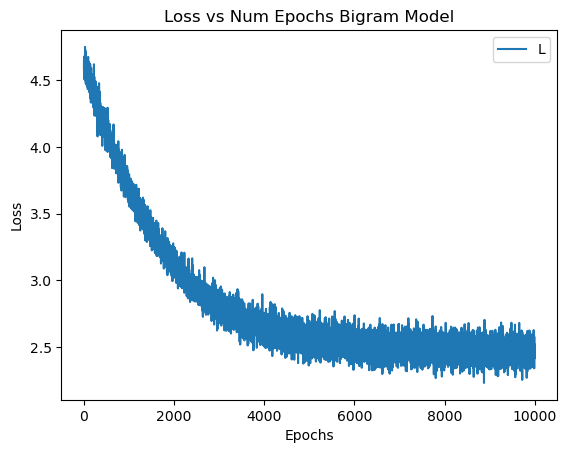

In [14]:
plt.plot([x for x in range(1,len(losses)+1)],losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend("Loss")
plt.title("Loss vs Num Epochs Bigram Model")